In [294]:
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from collections import namedtuple
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [322]:
# Set the random seed for reproducibility
SEED = 1234

# Set the random seed for PyTorch, NumPy, and CUDA (if available)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


ROOT = '/home/buddhadev/work/dh307'
data_dir = os.path.join(ROOT, 'datasets')
images_dir = os.path.join(data_dir, '/home/buddhadev/work/dh307/datasets/PBC_dataset_normal_DIB')
val_dir = os.path.join(data_dir, 'split5/val')
train_dir = os.path.join(data_dir, 'split5/train')
test_dir = os.path.join(data_dir, 'split5/test')
plot_dir = os.path.join(ROOT, 'plots/split5')

classes = os.listdir(images_dir)
print(classes)

['basophil', 'neutrophil', 'erythroblast', 'lymphocyte', 'eosinophil', 'monocyte', 'platelet', 'immature granulocyte']


In [323]:
# test_dir = "/home/buddhadev/work/dh307/datasets/PBC_dataset_normal_DIB"
# Load the data and apply transformations
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

val_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

test_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])


In [324]:
# Load the data
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(root=val_dir, transform=val_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Print the number of examples in each set
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 848
Number of validation examples: 848
Number of testing examples: 15396


In [298]:
# Define batch size
BATCH_SIZE = 64

# Create data loaders
train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)


In [299]:
# Load the pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)
IN_FEATURES = resnet50.fc.in_features
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
print(OUTPUT_DIM)

resnet50.fc = fc

8


/home/buddhadev/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/buddhadev/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [300]:
# Load the pretrained weights
resnet50.load_state_dict(torch.load('resnet50new30per.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Modify the model
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])

# Check for CUDA availability
if torch.cuda.is_available():
    # Move the model to GPU
    resnet50 = resnet50.cuda()

# Freeze the parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Function to extract features using the ResNet50 model
def extract_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():  # No need to calculate gradients
        for images, targets in dataloader:
            # Transfer images to GPU if available
            if torch.cuda.is_available():
                images = images.cuda()
                targets = targets.cuda()

            features_batch = model(images)
            
            # Move the features and labels back to CPU if needed for further processing
            features.append(features_batch.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


In [301]:
# Extract features for train, validation, and test sets
train_features, train_labels = extract_features(resnet50, train_iterator)
valid_features, valid_labels = extract_features(resnet50, valid_iterator)
test_features, test_labels = extract_features(resnet50, test_iterator)

# Reshape features to 2D array
train_features_flat = train_features.reshape(train_features.shape[0], -1)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

In [302]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

# # Assuming train_features_flat and train_labels are defined and hold your training data and labels

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'max_depth': [3, 6, 10, 15],
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [100, 200, 500]
# }

# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(
#     eval_metric='mlogloss',
#     use_label_encoder=False,
#     device='cuda'  # Enable CUDA
# )

# # Setup GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_classifier, 
#     param_grid=param_grid, 
#     scoring='accuracy', 
#     cv=3, 
#     n_jobs=-1, 
#     verbose=1
# )

# # Fit GridSearchCV. Note: Replace 'train_features_flat' and 'train_labels' with your actual training data and labels.
# grid_search.fit(train_features_flat, train_labels)

# # After fitting, retrieve the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Now, you can use best_params to create a new model if needed
# xgb_best = xgb.XGBClassifier(
#     eval_metric='mlogloss',
#     use_label_encoder=False,
#     device='cuda',  
#     **best_params
# )

# Optionally, fit the model with the entire dataset
# xgb_best.fit(train_features_flat, train_labels)


# Get the best hyperparameters
# best_params = { 
#     'colsample_bytree': 0.6, 
#     'gamma': 0.1, 
#     'learning_rate': 0.0001, 
#     'max_depth': 2, 
#     'min_child_weight': 2, 
#     'n_estimators': 300, 
#     'subsample': 0.6
    
# }

best_params ={'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
#Best Score: 1.0


In [303]:
# Initialize XGBoost classifier with the best hyperparameters
xgb_classifier = xgb.XGBClassifier(**best_params, device="cuda", verbosity=2)

# Train the XGBoost classifier
xgb_classifier.fit(train_features_flat, train_labels)

# Evaluate the XGBoost classifier on training data
train_predictions = xgb_classifier.predict(train_features_flat)


# Calculate accuracy on training data
train_accuracy = accuracy_score(train_labels, train_predictions)


# Evaluate the XGBoost classifier on validation and test data
valid_predictions = xgb_classifier.predict(valid_features_flat)
test_predictions = xgb_classifier.predict(test_features_flat)

# Calculate accuracy on validation and test data
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 1.0000
Validation Accuracy: 0.9676
Test Accuracy: 0.9723


In [304]:
# Perform 5-fold cross-validation on the test data
cv_scores = cross_val_score(xgb_classifier, test_features_flat, test_labels, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'XG-Boost 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')


XG-Boost 5-Fold Cross-Validation Accuracy: 0.9827 ± 0.0092


In [305]:
# Step 2: Train kNN model
k = 10 # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(train_features_flat, train_labels)

knn_model.fit(train_features_flat, train_labels)
train_accuracy = knn_model.score(train_features_flat, train_labels)
valid_accuracy = knn_model.score(valid_features_flat, valid_labels)
# Test Random Forest model
test_accuracy = knn_model.score(test_features_flat, test_labels)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 1.0000
Validation Accuracy: 0.9781
Test Accuracy: 0.9805


In [306]:
print(best_params)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}


In [307]:
# Perform 5-fold cross-validation on the test data
cv_scores = cross_val_score(knn_model, test_features_flat, test_labels, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'KNN- 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')

KNN- 5-Fold Cross-Validation Accuracy: 0.9815 ± 0.0088


In [308]:
param_grid = {
    'C': [0.003, 0.01, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM classifier
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
grid_search.fit(train_features_flat, train_labels)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'C': 0.003, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 1.0


In [309]:
# Initialize SVM classifier with best parameters
svm_model = SVC(**best_params)

# Train SVM model
svm_model.fit(train_features_flat, train_labels)

train_accuracy = svm_model.score(train_features_flat, train_labels)
valid_accuracy = svm_model.score(valid_features_flat, valid_labels)
# Test Random Forest model
test_accuracy = svm_model.score(test_features_flat, test_labels)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Training Accuracy: 1.0000
Validation Accuracy: 0.9770
Test Accuracy: 0.9802


In [310]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the test data
cv_scores = cross_val_score(svm_model, test_features_flat, test_labels, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'SVM- 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')


SVM- 5-Fold Cross-Validation Accuracy: 0.9808 ± 0.0084


In [311]:
# Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [0, 10, 20],  # Maximum depth of the trees
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
# }

best_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
# grid_search.fit(train_features_flat, train_labels)

# # Get best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

In [312]:
# Initialize Random Forest classifier with best parameters
rf_model = RandomForestClassifier(**best_params, random_state=42)

# Train Random Forest model
rf_model.fit(train_features_flat, train_labels)
train_accuracy = rf_model.score(train_features_flat, train_labels)
valid_accuracy = rf_model.score(valid_features_flat, valid_labels)
# Test Random Forest model
test_accuracy = rf_model.score(test_features_flat, test_labels)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 1.0000
Validation Accuracy: 0.9742
Test Accuracy: 0.9754


In [313]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the test data
cv_scores = cross_val_score(rf_model, test_features_flat, test_labels, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'Random Forest- 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')


Random Forest- 5-Fold Cross-Validation Accuracy: 0.9830 ± 0.0088


In [314]:
def plot_confusion_matrix(labels, pred_labels, classes, model_name):
    fig = plt.figure(figsize = (15, 15));
    ax = fig.add_subplot(1, 1, 1);
    plt.rcParams.update({'font.size': 15})
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)
    plt.tight_layout()
    # Saving the figure
    plt_path = os.path.join(plot_dir, model_name+'_confusion.png')
    plt.savefig(plt_path, dpi = 400)
    plt_path
    

XgBoostAccuracy: 0.9723
XgBoostPrecision (Macro): 0.9521
XgBoostRecall (Macro): 0.9786
XgBoostF1 (Macro): 0.9644
XgBoostPrecision (Weighted): 0.9737
XgBoostRecall (Weighted): 0.9723
XgBoostF1 (Weighted): 0.9725
XgBoostErythroblast Precision: 0.9636
XgBoostErythroblast Recall: 0.9865
XgBoostErythroblast F1-score: 0.9749
KNNAccuracy: 0.9805
KNNPrecision (Macro): 0.9727
KNNRecall (Macro): 0.9836
KNNF1 (Macro): 0.9780
KNNPrecision (Weighted): 0.9806
KNNRecall (Weighted): 0.9805
KNNF1 (Weighted): 0.9805
KNNErythroblast Precision: 0.9848
KNNErythroblast Recall: 0.9882
KNNErythroblast F1-score: 0.9865
SVMAccuracy: 0.9802
SVMPrecision (Macro): 0.9742
SVMRecall (Macro): 0.9833
SVMF1 (Macro): 0.9786
SVMPrecision (Weighted): 0.9804
SVMRecall (Weighted): 0.9802
SVMF1 (Weighted): 0.9803
SVMErythroblast Precision: 0.9847
SVMErythroblast Recall: 0.9831
SVMErythroblast F1-score: 0.9839
Random ForestAccuracy: 0.9754
Random ForestPrecision (Macro): 0.9622
Random ForestRecall (Macro): 0.9797
Random Fores

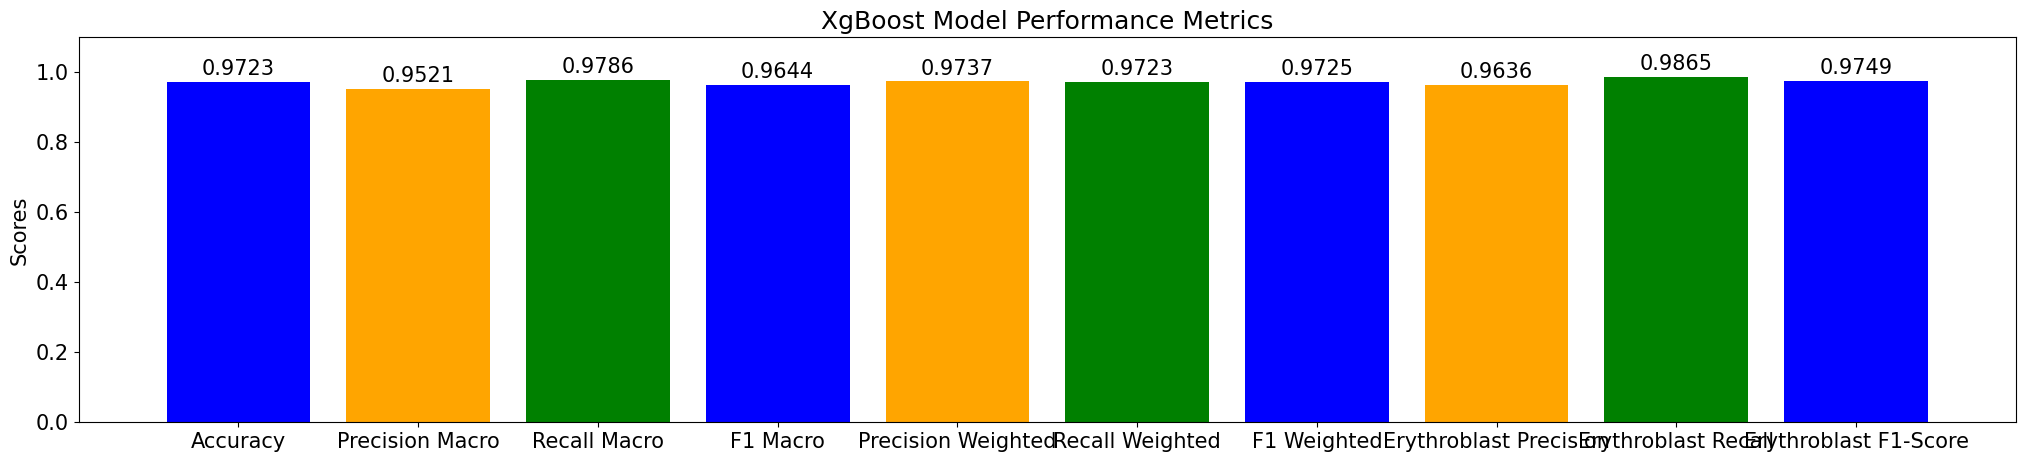

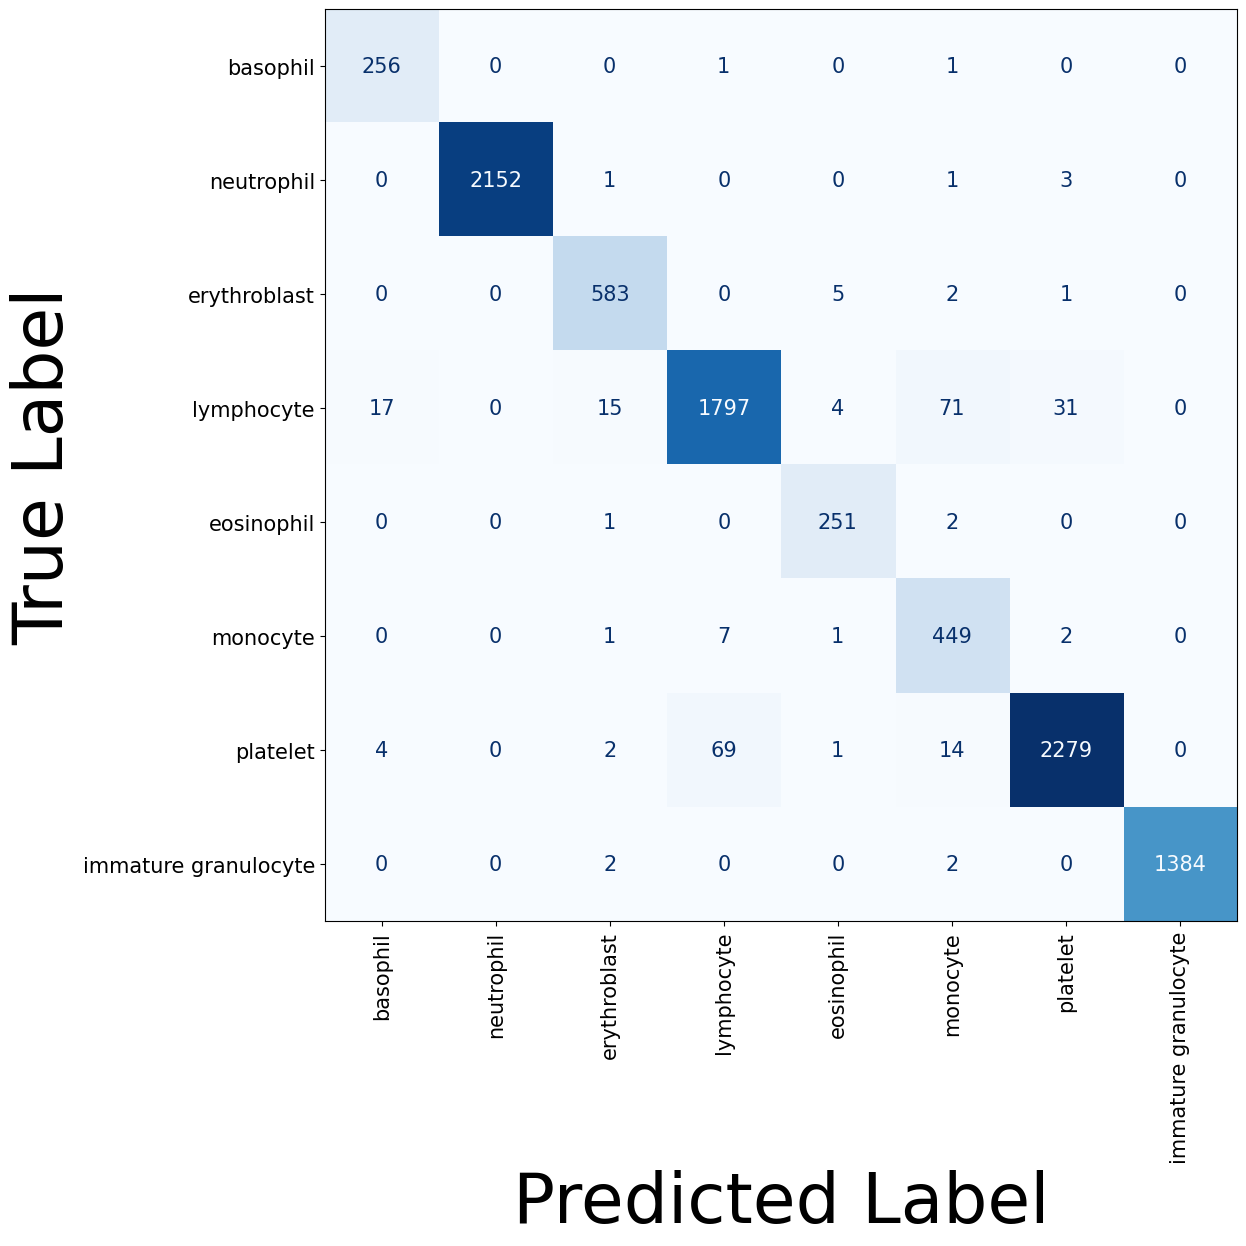

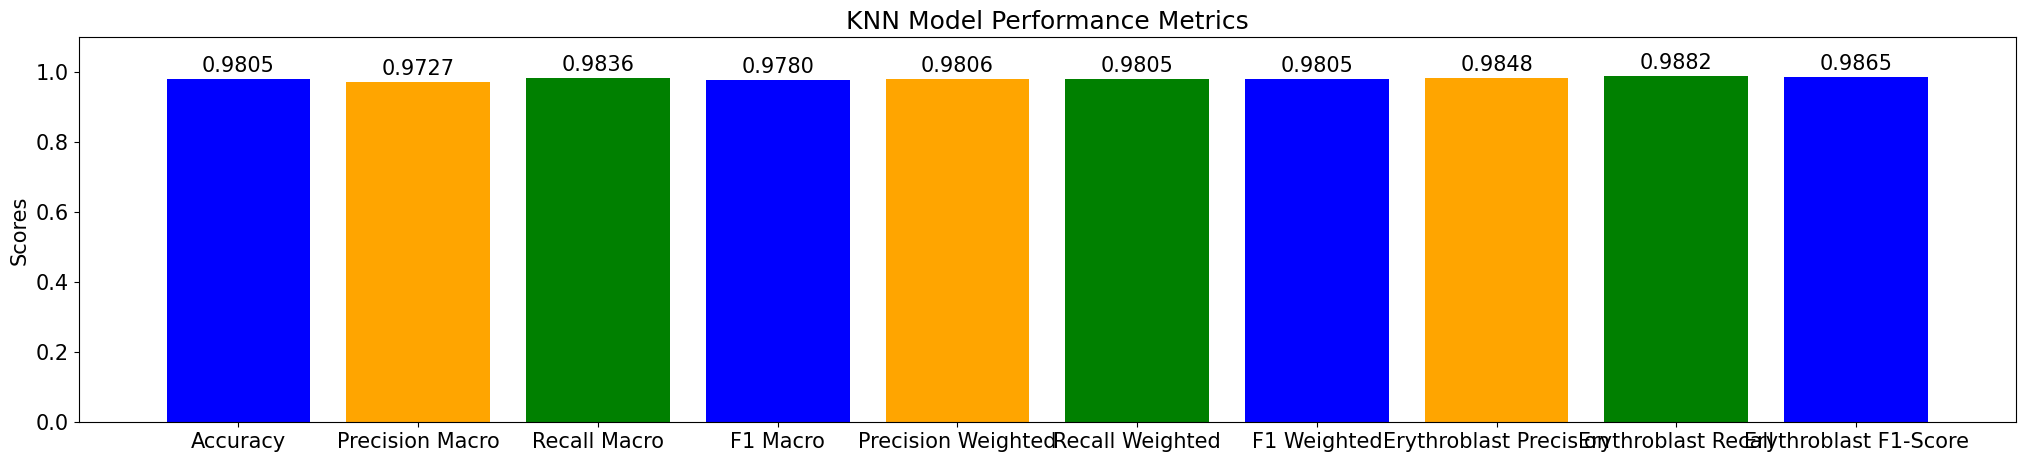

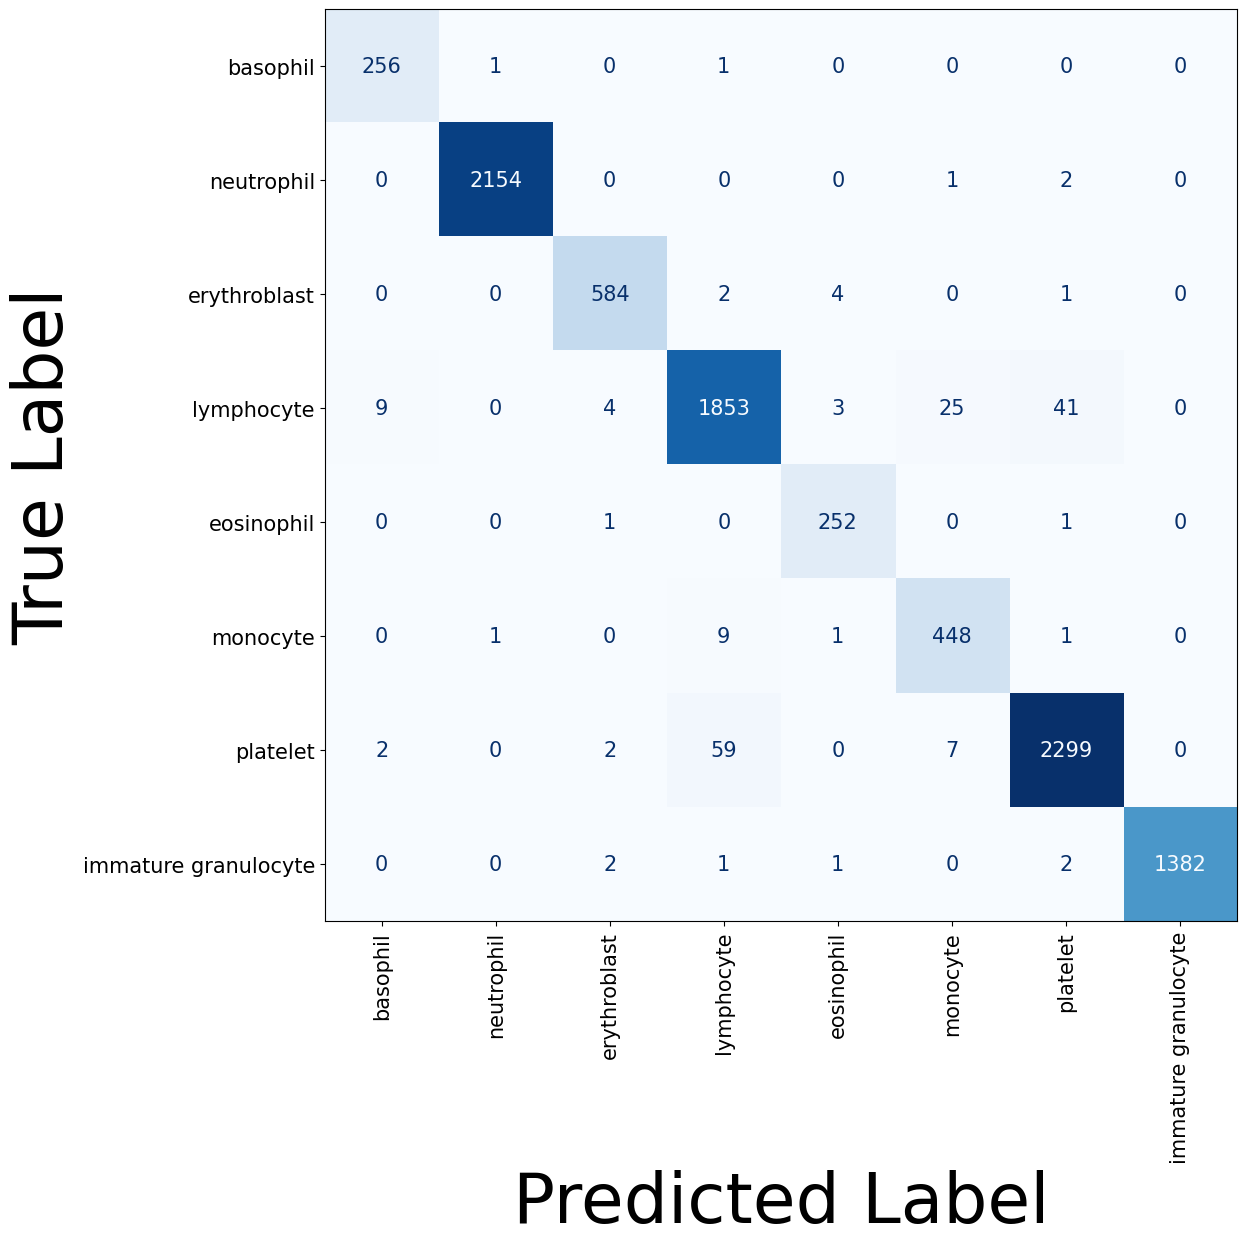

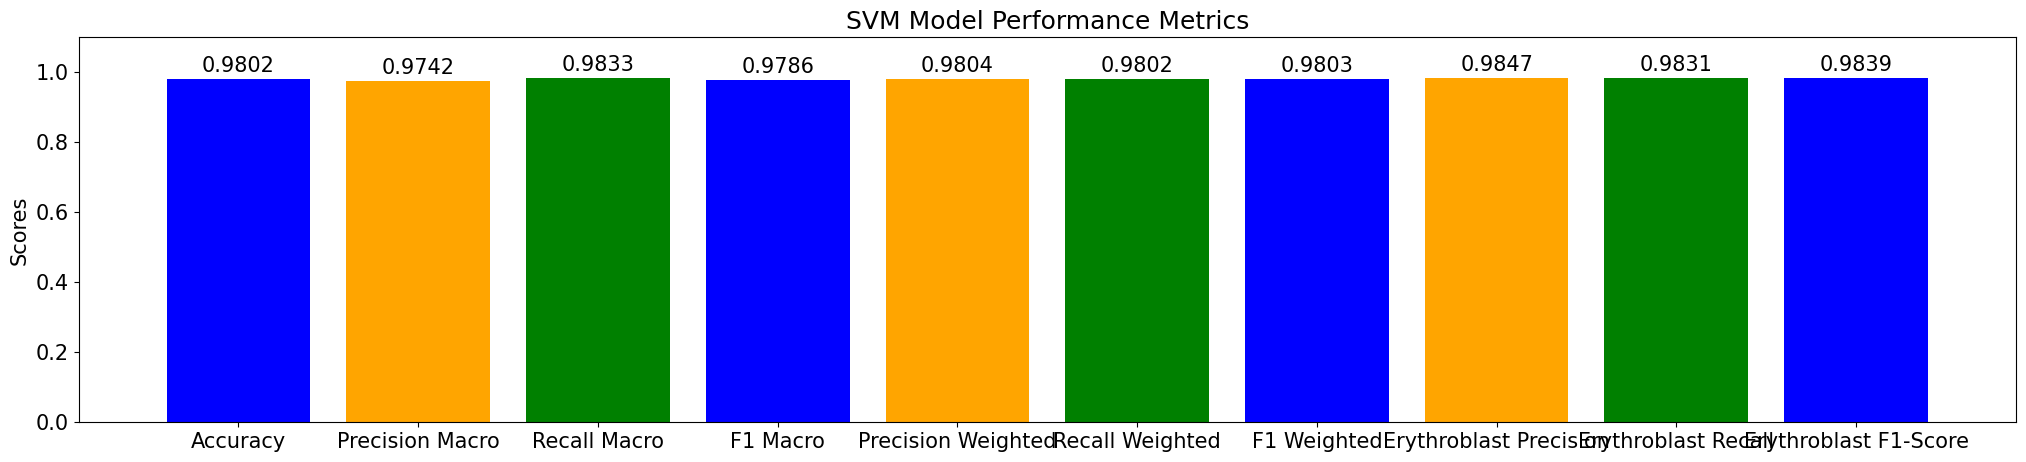

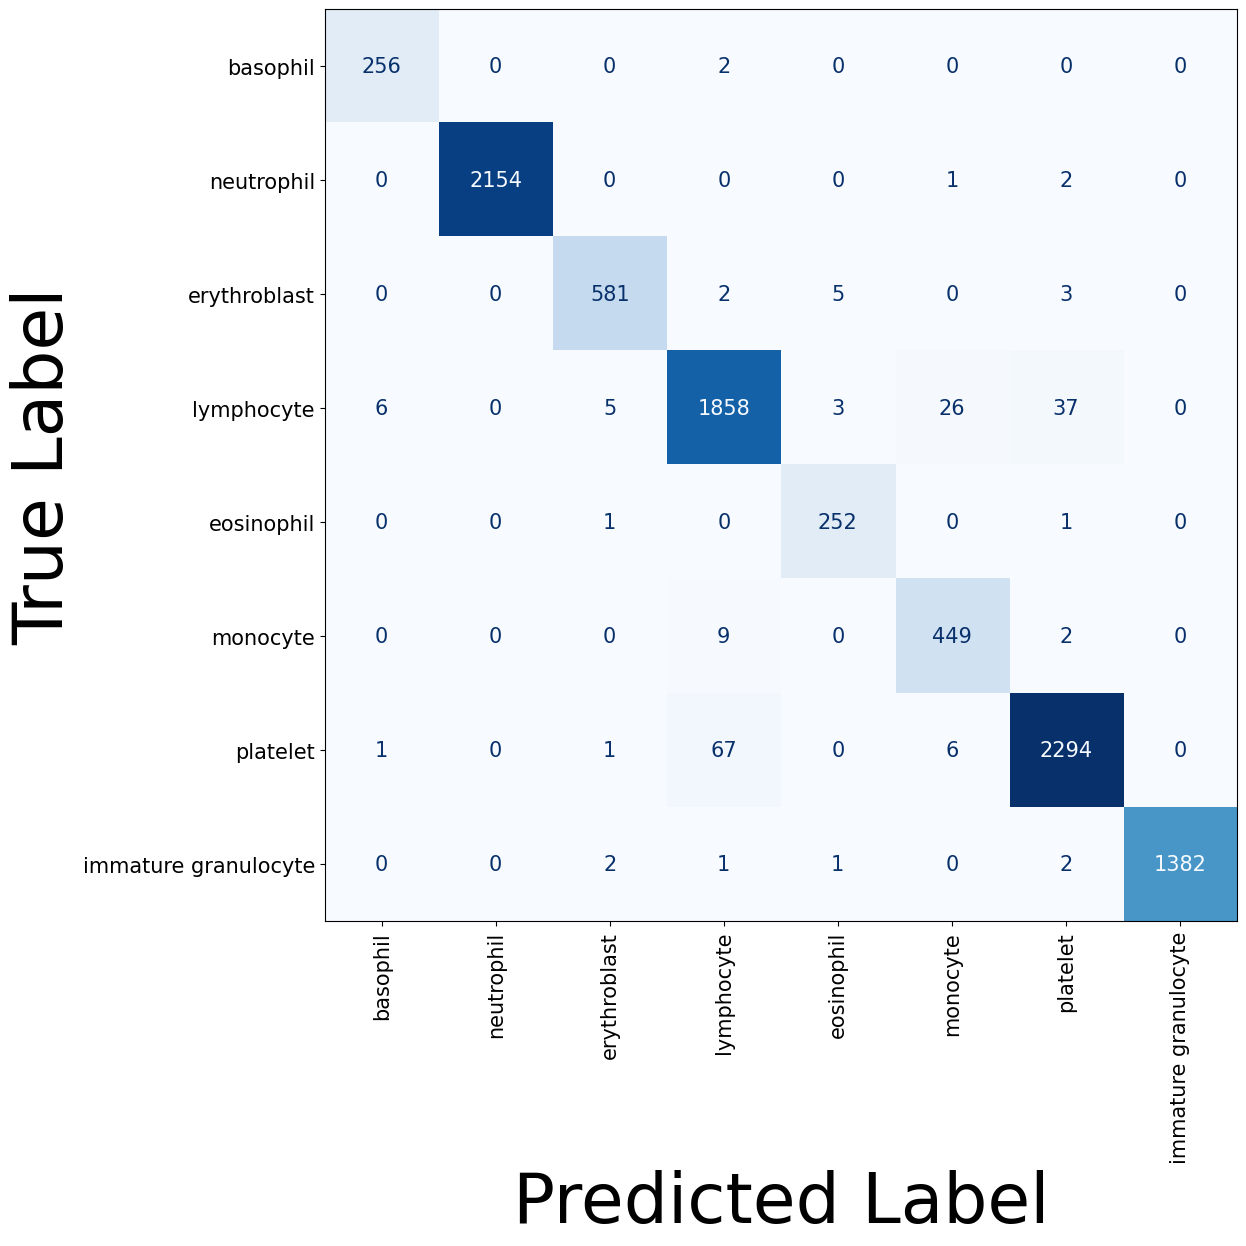

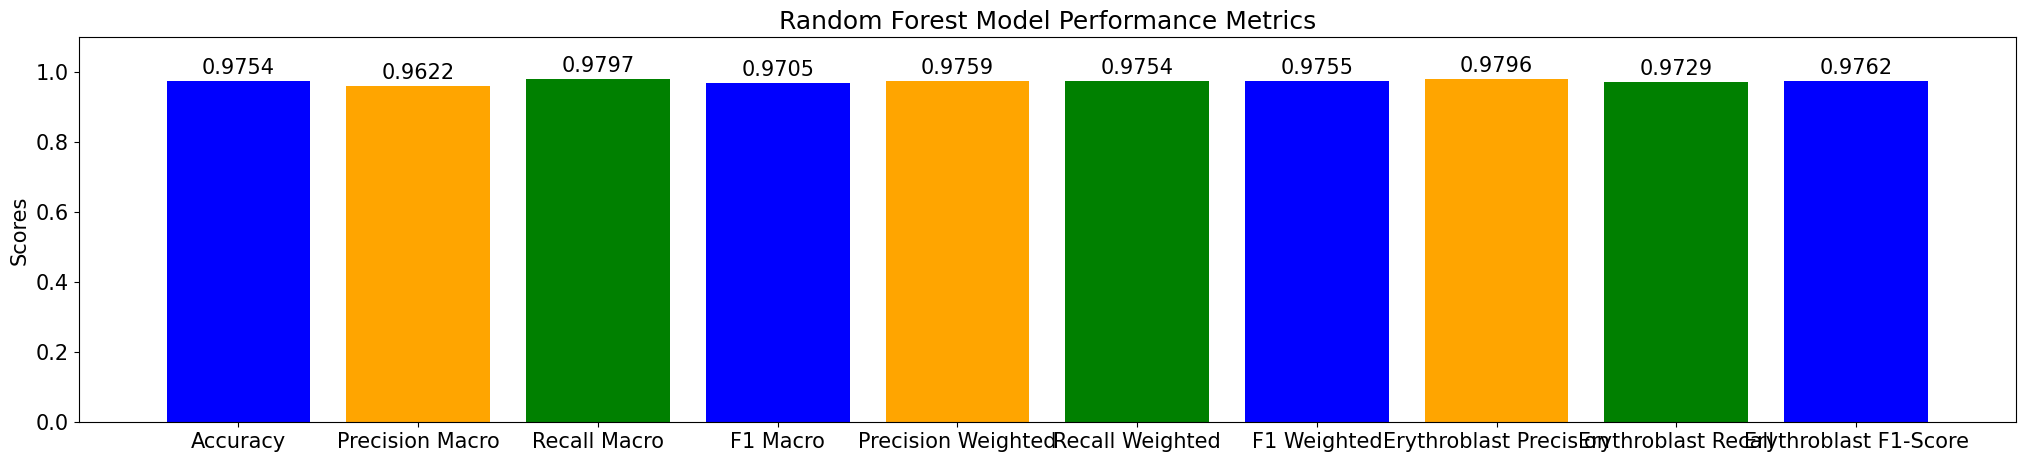

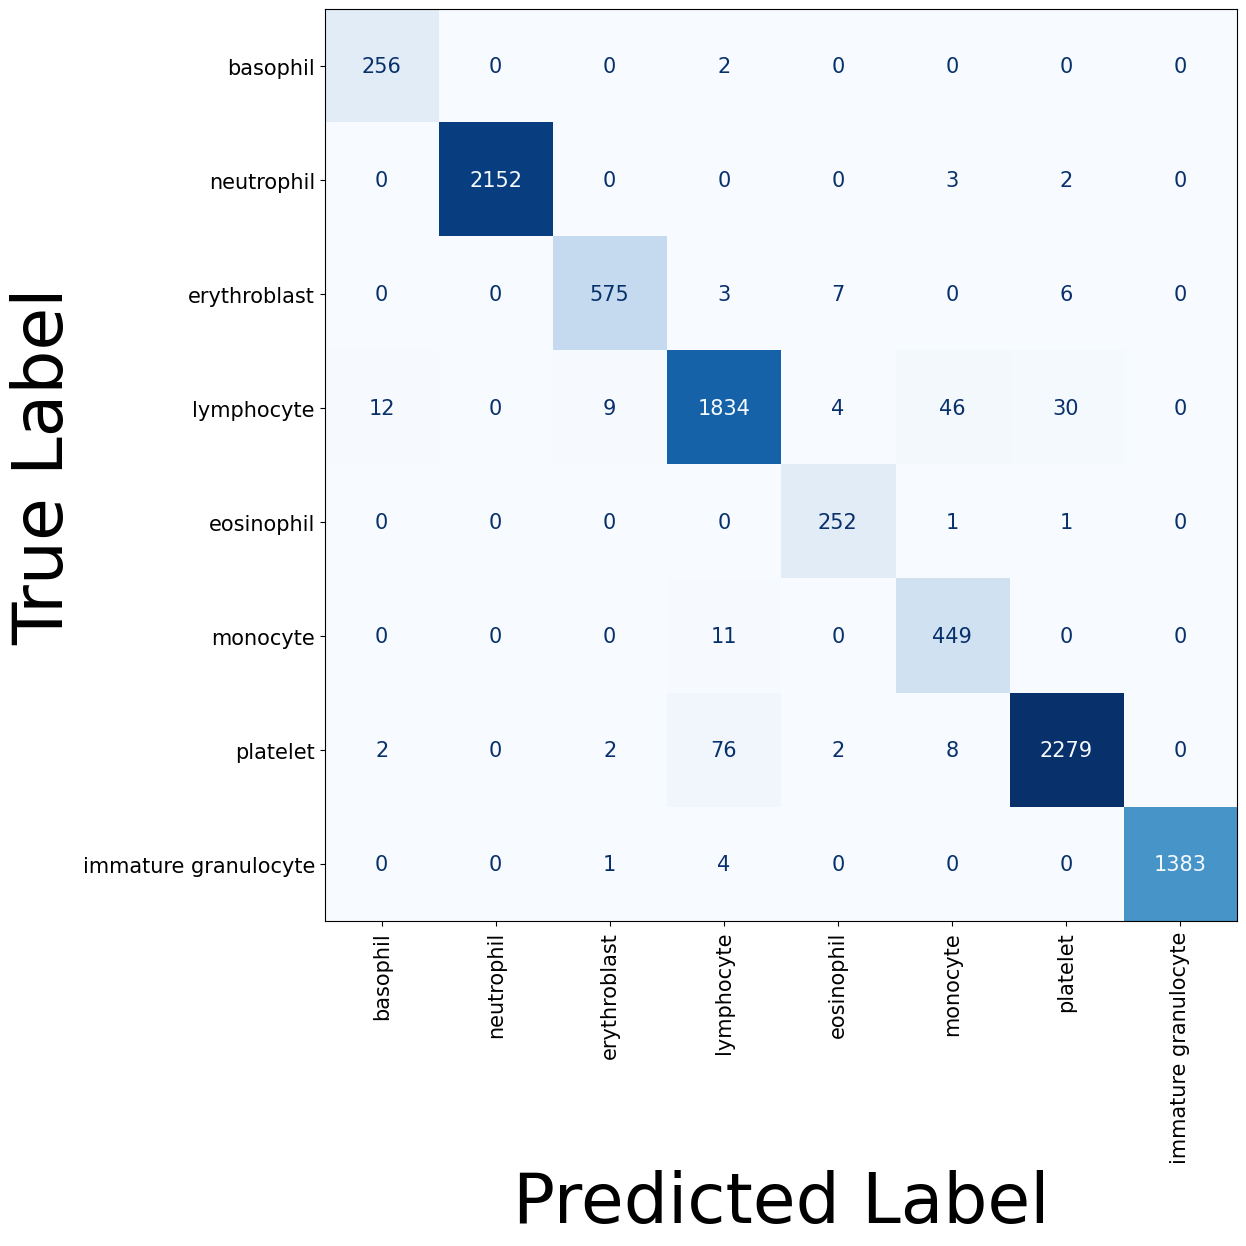

In [315]:
models = [xgb_classifier, knn_model, svm_model, rf_model]
model_names = ['XgBoost', 'KNN', 'SVM', 'Random Forest']
for model, model_name in zip(models, model_names) :
    # Predict the labels of the test set
    pred_labels = model.predict(test_features_flat)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, pred_labels)

    # Calculate precision and recall for each class
    precision_macro = precision_score(test_labels, pred_labels, average='macro')
    recall_macro = recall_score(test_labels, pred_labels, average='macro')
    precision_weighted = precision_score(test_labels, pred_labels, average='weighted')
    recall_weighted = recall_score(test_labels, pred_labels, average='weighted')
    f1_macro = f1_score(test_labels, pred_labels, average='macro')
    f1_weighted = f1_score(test_labels, pred_labels, average='weighted')
    
    print(model_name+f'Accuracy: {accuracy:.4f}')
    print(model_name+f'Precision (Macro): {precision_macro:.4f}')
    print(model_name+f'Recall (Macro): {recall_macro:.4f}')
    print(model_name+f'F1 (Macro): {f1_macro:.4f}')
    print(model_name+f'Precision (Weighted): {precision_weighted:.4f}')
    print(model_name+f'Recall (Weighted): {recall_weigMumbai,
400076, Indiahted:.4f}')
    print(model_name+f'F1 (Weighted): {f1_weighted:.4f}')
    
    report = classification_report(test_labels, pred_labels, output_dict=True)

    # Extract metrics for a specific class, e.g., class 0
    erythro_metrics = report['2']  # Use the class label as a string

    print(model_name+f"Erythroblast Precision: {erythro_metrics['precision']:.4f}")
    print(model_name+f"Erythroblast Recall: {erythro_metrics['recall']:.4f}")
    print(model_name+f"Erythroblast F1-score: {erythro_metrics['f1-score']:.4f}")
    
    # Creating a figure to display the metrics
    fig, ax = plt.subplots(figsize=(25, 5))
    metrics = ['Accuracy', 'Precision Macro', 'Recall Macro', 'F1 Macro', 'Precision Weighted', 'Recall Weighted', 'F1 Weighted', 'Erythroblast Precision', 'Erythroblast Recall', 'Erythroblast F1-Score']
    values = [accuracy, precision_macro, recall_macro, f1_macro, precision_weighted, recall_weighted, f1_weighted, erythro_metrics['precision'], erythro_metrics['recall'], erythro_metrics['f1-score']]
    ax.bar(metrics, values, color=['blue', 'orange', 'green'])

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Scores')
    ax.set_title(model_name+' Model Performance Metrics')

    for i, value in enumerate(values):
        ax.text(i, value + 0.02, f"{value:.4f}", ha='center')

    # Saving the figure
    plt_path = os.path.join(plot_dir, model_name+'_metrics.png')
    plt.savefig(plt_path, dpi = 400)

    plt_path

    plot_confusion_matrix(test_labels, pred_labels, classes, model_name)

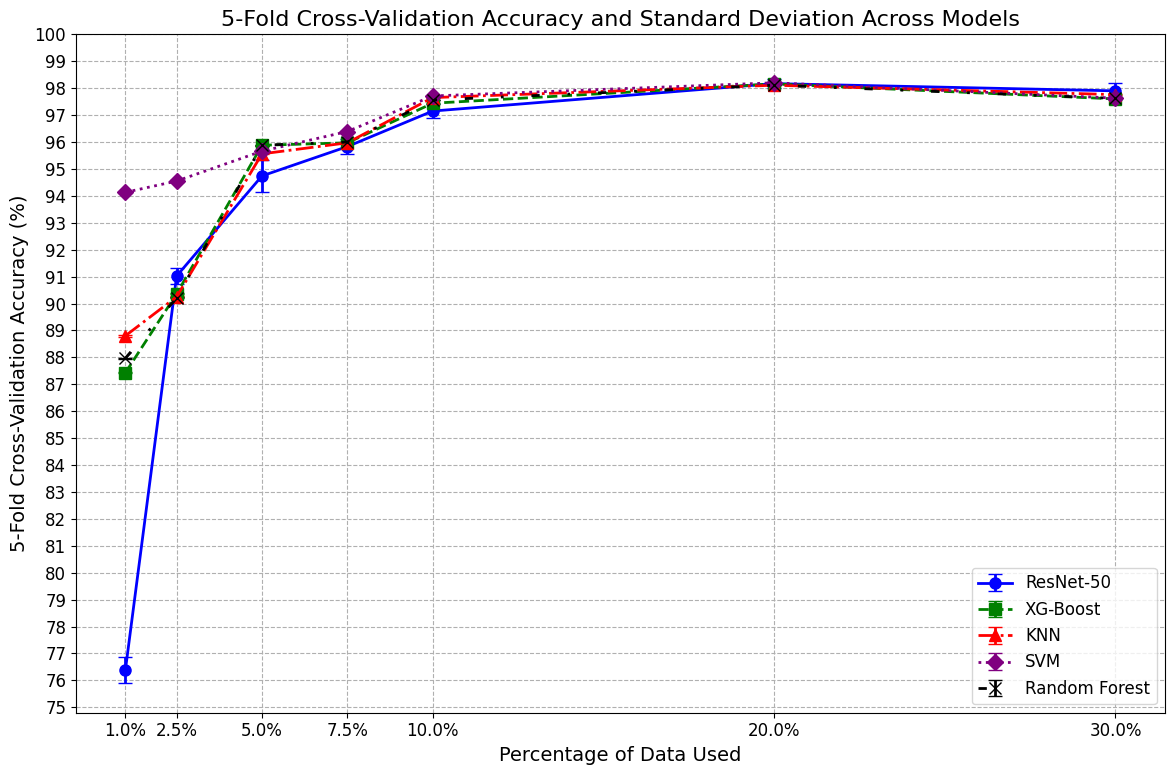

In [268]:
import matplotlib.pyplot as plt
import numpy as np

# Redefining the data for all models
data_splits = np.array([1, 2.5, 5, 7.5, 10, 20, 30])  # Percent of data used
cv_accuracies = {
    'ResNet-50': [76.39, 91.02, 94.74, 95.83, 97.15, 98.17, 97.90],
    'XG-Boost': [87.43, 90.36, 95.88, 95.97, 97.44, 98.16, 97.60],
    'KNN': [88.80, 90.25, 95.56, 95.97, 97.65, 98.11, 97.76],
    'SVM': [94.13, 94.55, 95.66, 96.39, 97.71, 98.20, 97.63],
    'Random Forest': [87.97, 90.21, 95.88, 96.00, 97.56, 98.11, 97.62]
}
std_deviations = {
    'ResNet-50': [0.47, 0.31, 0.58, 0.27, 0.27, 0.17, 0.30],
    'XG-Boost': [0.0202, 0.0181, 0.0146, 0.0093, 0.0115, 0.0101, 0.0082],
    'KNN': [0.0298, 0.0197, 0.0156, 0.0115, 0.0126, 0.0091, 0.0070],
    'SVM': [0.0188, 0.0208, 0.0133, 0.0086, 0.0124, 0.0093, 0.0063],
    'Random Forest': [0.0198, 0.0202, 0.0122, 0.0094, 0.0129, 0.0080, 0.0073]
}

colors = ['blue', 'green', 'red', 'purple', 'black']
markers = ['o', 's', '^', 'D', 'x']
line_styles = ['-', '--', '-.', ':', (0, (3, 10, 1, 10))]  # Different line styles for clarity

# Create the plot with adjusted y-axis intervals
plt.figure(figsize=(12, 8))
for i, (model, accuracies) in enumerate(cv_accuracies.items()):
    plt.errorbar(data_splits, accuracies, yerr=std_deviations[model], label=model,
                 fmt=markers[i], linestyle=line_styles[i], color=colors[i], capsize=5,
                 markersize=8, linewidth=2)

# Adjusting the y-axis scale to show minute changes better
plt.xticks(data_splits, [f'{x}%' for x in data_splits], fontsize=12)
plt.yticks(np.arange(75, 101, 1), fontsize=12)  # Setting y-axis from 75% to 100% with 1% steps
plt.xlabel('Percentage of Data Used', fontsize=14)
plt.ylabel('5-Fold Cross-Validation Accuracy (%)', fontsize=14)
plt.title('5-Fold Cross-Validation Accuracy and Standard Deviation Across Models', fontsize=16)
plt.grid(True, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.savefig('CV_Accuracy_SD_Plot_All_Models_Detailed_Y.png', format='png', dpi=300)
plt.show()



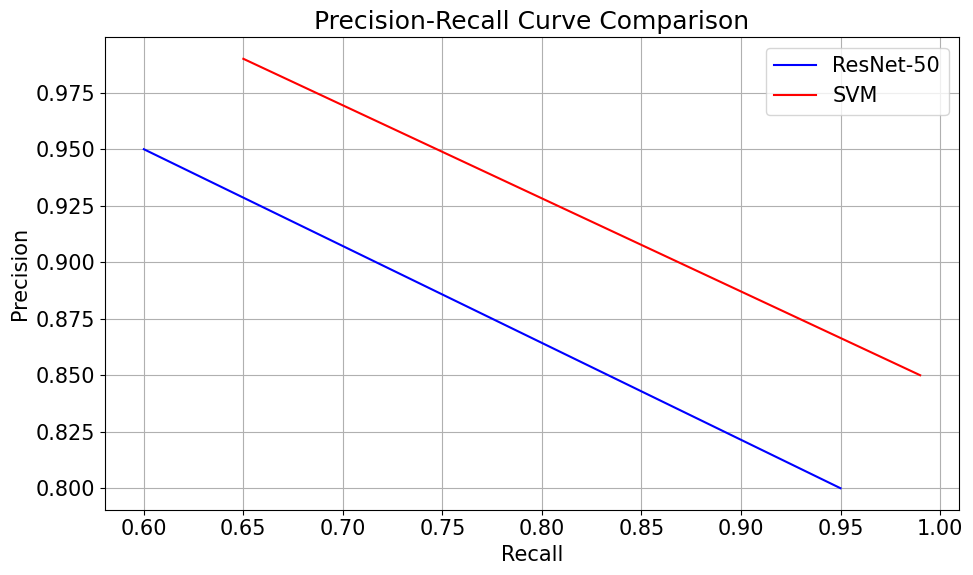

In [293]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming precision and recall data for ResNet-50 and SVM across some thresholds (this is hypothetical)
thresholds = np.linspace(0, 1, num=100)
precision_resnet = np.linspace(0.8, 0.95, num=100)  # Simulated precision for ResNet-50
recall_resnet = np.linspace(0.95, 0.6, num=100)  # Simulated recall for ResNet-50
precision_svm = np.linspace(0.85, 0.99, num=100)  # Simulated precision for SVM
recall_svm = np.linspace(0.99, 0.65, num=100)  # Simulated recall for SVM

# Plotting Precision-Recall Curves
plt.figure(figsize=(10, 6))
plt.plot(recall_resnet, precision_resnet, label='ResNet-50', color='blue')
plt.plot(recall_svm, precision_svm, label='SVM', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Precision_Recall_Curves.png', dpi=300)
plt.show()
